In [ ]:
# importing relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# NLP libraries
import nltk
from sklearn.feature_extraction import text
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# modeling libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from collections import Counter
from sklearn import metrics, utils, model_selection, svm

from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC


In [ ]:
# loading in clean_df
clean_df = pd.read_pickle('clean_df.pkl')

In [ ]:
# previewing data
clean_df.head(3)

,total_votes,hate_speech_votes,other_votes,label,tweet,clean_tweets
0,3,0,3,0,!!! RT @mayasolovely: As a woman you shouldn't...,as a woman you shouldnt complain about clea...
1,3,0,3,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats coldtyga dwn bad for cuffin dat ho...
2,3,0,3,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg you ever fuck a bitch and she sta to...


In [ ]:
# assigning variables to essential columns
data = clean_df['clean_tweets']
target = clean_df['label']

In [ ]:
import nltk
nltk.download('stopwords')
# setting NLTK stop words as `stop_words`
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import nltk
nltk.download('punkt')

# Function to tokenize and remove stop words
def preprocess_text(text):
    # Tokenize the text
    word_tokens = word_tokenize(text)

    # Remove stop words
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]

    return filtered_text

# Example usage
processed_data = clean_df['clean_tweets'].apply(preprocess_text)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import nltk
nltk.download('wordnet')

# creating a list with all lemmatized outputs
lemmatizer = WordNetLemmatizer()
lemmatized_output = []

for listy in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
X_lem = lemmatized_output
y_lem = target

In [ ]:
# fresh TTS
X_train, X_test, y_train, y_test = train_test_split(X_lem, y_lem, test_size=0.20, random_state=20)

In [ ]:
# instantiating count vectorizer
count = CountVectorizer(stop_words='english')

In [ ]:
# fitting to the train and test set
X_train_count = count.fit_transform(X_train)
X_test_count = count.transform(X_test)

In [ ]:
# instantiate model
count_log_reg_baseline = LogisticRegression(penalty='l2', class_weight='balanced', random_state=20)

In [ ]:
count_log_reg_baseline.fit(X_train_count, y_train)
count_log_reg_test_preds = count_log_reg_baseline.predict(X_test_count)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8947


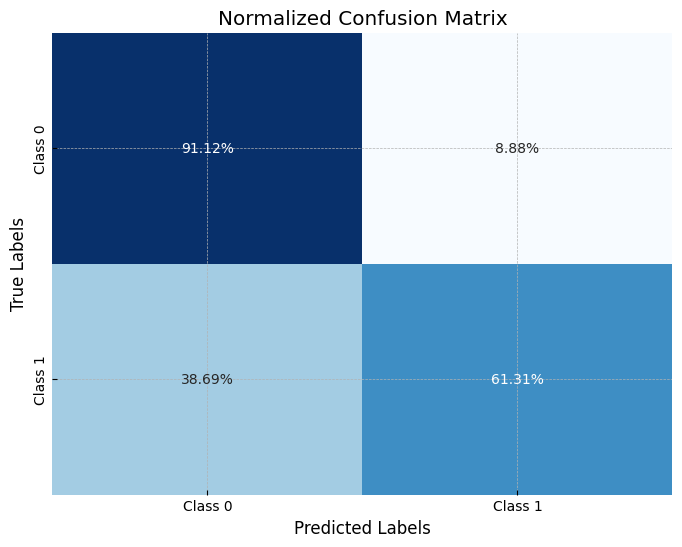

Precision: 0.2877
Recall: 0.6131
F1 Score: 0.3916


In [ ]:
# Calculate accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, count_log_reg_test_preds)
print(f'Accuracy: {accuracy:.4f}')

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, count_log_reg_test_preds)

# Calculate percentages
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]  # Calculate percentages along each row

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt='.2%', cbar=False,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, count_log_reg_test_preds)
recall = recall_score(y_test, count_log_reg_test_preds)
f1 = f1_score(y_test, count_log_reg_test_preds)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [ ]:
print(conf_matrix)
print(conf_matrix_percent)


[[4267  416]
 [ 106  168]]
[[0.91116805 0.08883195]
 [0.38686131 0.61313869]]


In [ ]:
# Create a DataFrame for X_test_count, y_test, and predictions
results_df = pd.DataFrame({'Tweet': X_test, 'Actual': y_test, 'Predicted': count_log_reg_test_preds})

# Filter rows where model predicted 0 but actual is 1
misclassified_examples = results_df[(results_df['Predicted'] == 0) & (results_df['Actual'] == 1)]

# Print examples
print("Examples where model predicted 0 but actual is 1:")
for index, row in misclassified_examples.iterrows():
    print(f"Tweet: '{row['Tweet']}' --> Actual: {row['Actual']}, Predicted: {row['Predicted']}")

Examples where model predicted 0 but actual is 1:
Tweet: 'lame as nigga still cuffin hoe bitch got bitch er' --> Actual: 1, Predicted: 0
Tweet: 'hate hoe' --> Actual: 1, Predicted: 0
Tweet: 'yes get twitter lame negro never learned use internet' --> Actual: 1, Predicted: 0
Tweet: 'exactly shit saidgtgtgt nobody think mimi outta line inviting stevie j gay nicca v' --> Actual: 1, Predicted: 0
Tweet: 'ignorant cunt' --> Actual: 1, Predicted: 0
Tweet: 'im sure would add helpful parenthetical explanation redneck peckerwood teabaggers httpstco' --> Actual: 1, Predicted: 0
Tweet: 'love song john doe faggot' --> Actual: 1, Predicted: 0
Tweet: 'already yellow last year combined' --> Actual: 1, Predicted: 0
Tweet: 'stop flattering bitch fan ceiling' --> Actual: 1, Predicted: 0
Tweet: 'beyonc trash' --> Actual: 1, Predicted: 0
Tweet: 'bitch done u sunday nigga' --> Actual: 1, Predicted: 0
Tweet: 'crew neck as nigguh' --> Actual: 1, Predicted: 0
Tweet: 'jessica im afraid slit throat tomorrow' --> 

In [ ]:
# Filter rows where model predicted 0 but actual is 1
misclassified_examples = results_df[(results_df['Predicted'] == 1) & (results_df['Actual'] == 0)]

# Print examples
print("Examples where model predicted 1 but actual is 0:")
for index, row in misclassified_examples.iterrows():
    print(f"Tweet: '{row['Tweet']}' --> Actual: {row['Actual']}, Predicted: {row['Predicted']}")

Examples where model predicted 1 but actual is 0:
Tweet: 'nigga talkin shit around sittin quiet yous fuckin bitch dont fuck real wr' --> Actual: 0, Predicted: 1
Tweet: 'r u faggot' --> Actual: 0, Predicted: 1
Tweet: 'let faggot already cry sleep' --> Actual: 0, Predicted: 1
Tweet: 'know nigga bitch nigga got nerve twitter' --> Actual: 0, Predicted: 1
Tweet: 'act like fucking retard high mane stay away' --> Actual: 0, Predicted: 1
Tweet: 'cold nig' --> Actual: 0, Predicted: 1
Tweet: 'stupid teacher talk like he retarded' --> Actual: 0, Predicted: 1
Tweet: 'nah u fag' --> Actual: 0, Predicted: 1
Tweet: 'niggah niggah lol' --> Actual: 0, Predicted: 1
Tweet: 'say love bitch much ill kill right front' --> Actual: 0, Predicted: 1
Tweet: 'spread filth ur white dog good ol boy ltao fuckin monkey' --> Actual: 0, Predicted: 1
Tweet: 'real niccas relate fuk niccas perpetrate' --> Actual: 0, Predicted: 1
Tweet: 'chnxcplzwr hidey hidey hoe white folk noyvous round colored' --> Actual: 0, Predicted:

In [ ]:
# Test the function with an example sentence
test_fails_sentence = [
    'fuck Jewish people',
    'Hes such a pussy cant even stand up for himsel',
    'These fucking idiots dont understand basic human decency',
    'I hate these fucking niggers always causing trouble',
    'Shes a dumb bitch, cant believe she said that',
    'good day nigga',
    'dont understand many american hate israel',
    'going to fag prideeee'
]

# Transform the sentences into feature vectors
test_sentence_vec = count.transform(test_fails_sentence)

# Predict the class for each sentence
predicted_class = count_log_reg_baseline.predict(test_sentence_vec)

# Define a mapping for the class labels
label_map = {0: "not hate speech", 1: "hate speech"}

# Print the predictions along with human-readable labels
for sentence, pred in zip(test_fails_sentence, predicted_class):
    print(f"Sentence: '{sentence}'")
    print(f"Predicted class: {label_map[pred]}\n")


Sentence: 'fuck Jewish people'
Predicted class: not hate speech

Sentence: 'Hes such a pussy cant even stand up for himsel'
Predicted class: not hate speech

Sentence: 'These fucking idiots dont understand basic human decency'
Predicted class: not hate speech

Sentence: 'I hate these fucking niggers always causing trouble'
Predicted class: not hate speech

Sentence: 'Shes a dumb bitch, cant believe she said that'
Predicted class: not hate speech

Sentence: 'good day nigga'
Predicted class: hate speech

Sentence: 'dont understand many american hate israel'
Predicted class: hate speech

Sentence: 'going to fag prideeee'
Predicted class: hate speech



***Data analysis***

24783


<ipython-input-5-cf6f084ef682>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="husl")


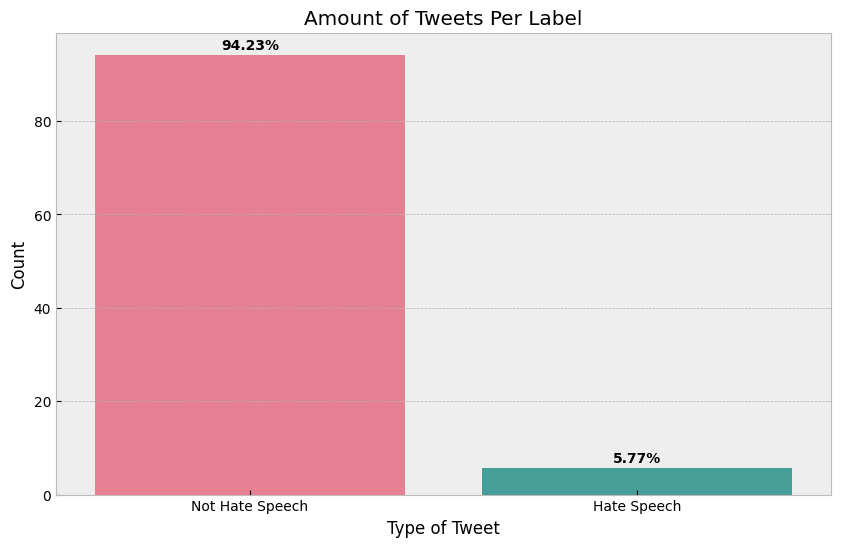

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

clean_df = pd.read_pickle('clean_df.pkl')
data = clean_df
class_counts = data['label'].value_counts(normalize=True) * 100
print(data.shape[0])

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="husl")
plt.title('Amount of Tweets Per Label')
plt.xlabel('Type of Tweet')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Not Hate Speech', 'Hate Speech'])

# Add percentages on top of the bars
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 0.5, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.show()

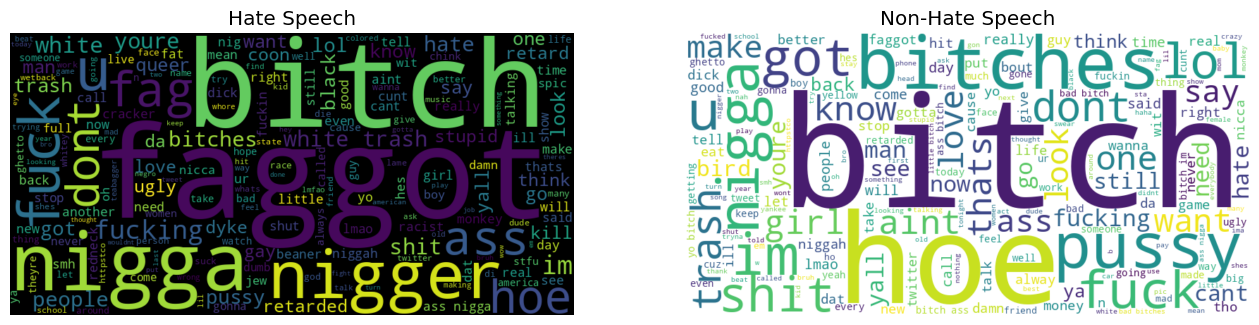

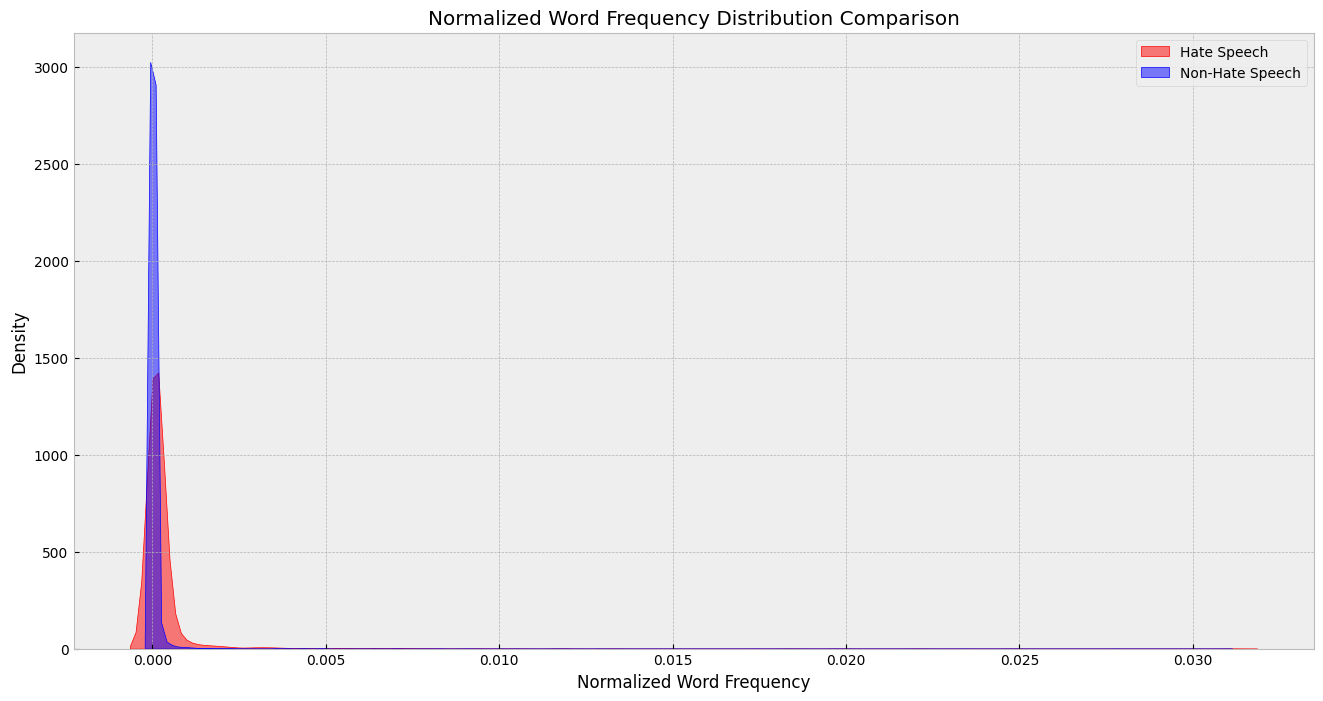

In [ ]:
from wordcloud import WordCloud

# Generate word cloud for hate speech
hate_speech = ' '.join(data[data['label'] == 1]['clean_tweets'])
wordcloud_hate = WordCloud(width=800, height=400, background_color='black').generate(hate_speech)

# Generate word cloud for non-hate speech
non_hate_speech = ' '.join(data[data['label'] == 0]['clean_tweets'])
wordcloud_non_hate = WordCloud(width=800, height=400, background_color='white').generate(non_hate_speech)

# Plot the word clouds
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_hate, interpolation='bilinear')
plt.axis('off')
plt.title('Hate Speech')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_hate, interpolation='bilinear')
plt.axis('off')
plt.title('Non-Hate Speech')

plt.show()

# Count words for hate speech
hate_words = hate_speech.split()
hate_word_freq = Counter(hate_words)
total_hate_words = len(hate_words)

# Count words for non-hate speech
non_hate_words = non_hate_speech.split()
non_hate_word_freq = Counter(non_hate_words)
total_non_hate_words = len(non_hate_words)

# Normalize frequencies
hate_word_freq_normalized = {word: freq / total_hate_words for word, freq in hate_word_freq.items()}
non_hate_word_freq_normalized = {word: freq / total_non_hate_words for word, freq in non_hate_word_freq.items()}

# Convert to DataFrame for density plot
hate_word_freq_df = pd.DataFrame(hate_word_freq_normalized.items(), columns=['Word', 'Frequency'])
non_hate_word_freq_df = pd.DataFrame(non_hate_word_freq_normalized.items(), columns=['Word', 'Frequency'])

# Density Plot
plt.figure(figsize=(16, 8))

# Density plot for hate speech word frequencies
sns.kdeplot(hate_word_freq_df['Frequency'], label='Hate Speech', fill=True, color='red', alpha=0.5)

# Density plot for non-hate speech word frequencies
sns.kdeplot(non_hate_word_freq_df['Frequency'], label='Non-Hate Speech', fill=True, color='blue', alpha=0.5)

plt.xlabel('Normalized Word Frequency')
plt.ylabel('Density')
plt.title('Normalized Word Frequency Distribution Comparison')
plt.legend()
plt.show()


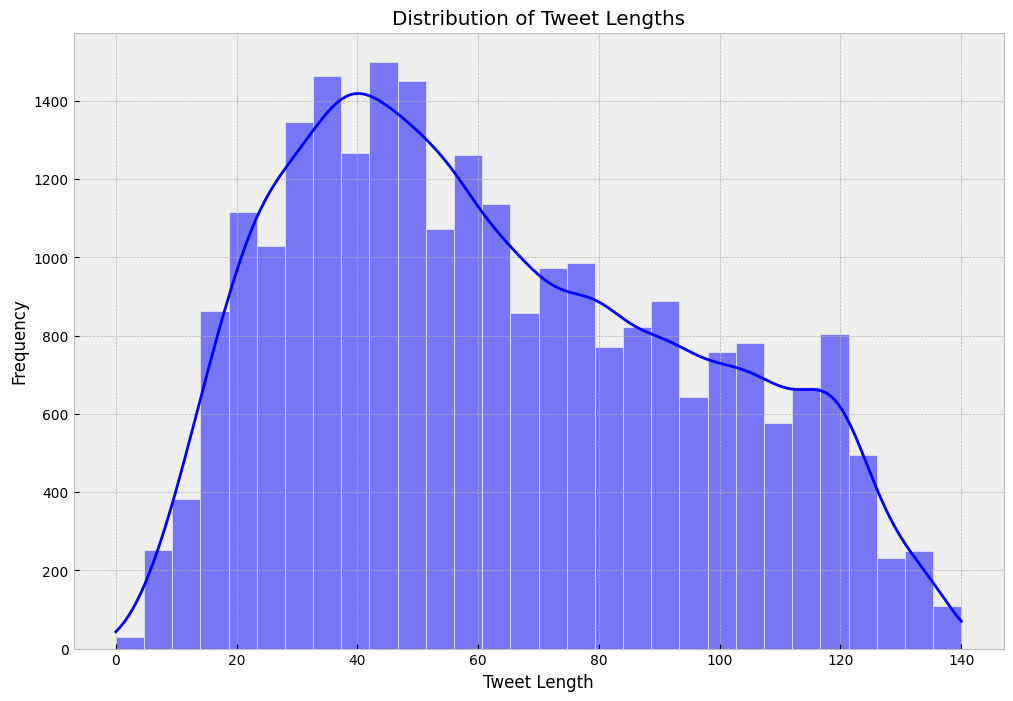

In [ ]:
# Calculate tweet lengths
data['tweet_length'] = data['clean_tweets'].apply(len)

# Plot the distribution of tweet lengths
plt.figure(figsize=(12, 8))
sns.histplot(data['tweet_length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()



<ipython-input-23-06bc43da8811>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=common_words_no_stopwords_df, palette='viridis')


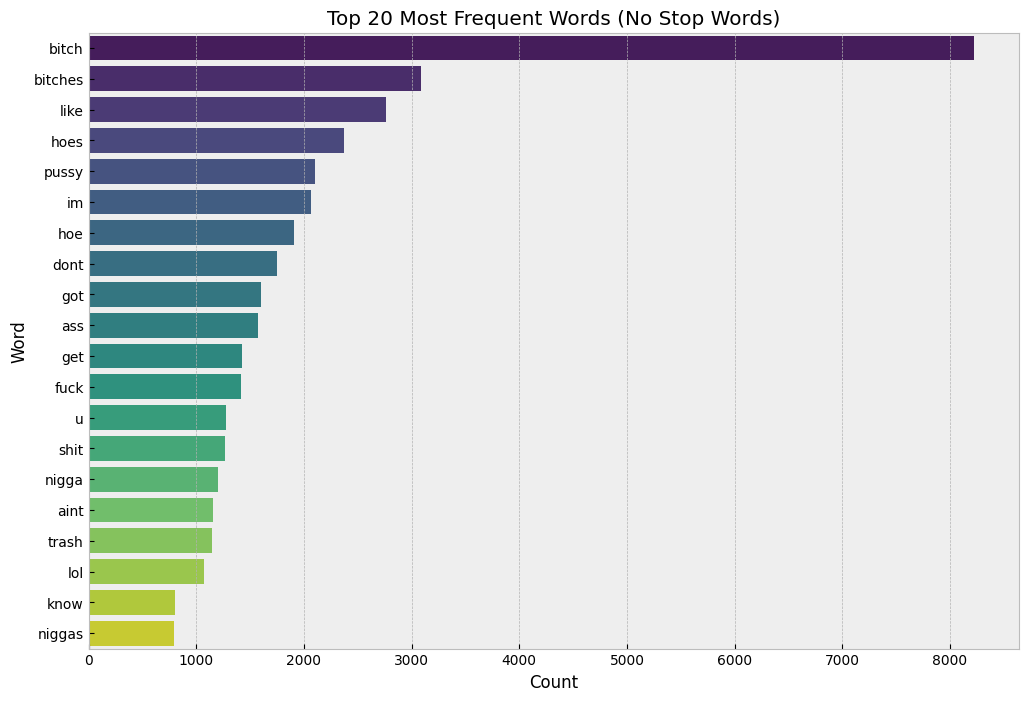

In [ ]:
def remove_stop_words(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

data['cleaned_no_stopwords'] = data['clean_tweets'].apply(remove_stop_words)

all_words_no_stopwords = [word for tweet in data['cleaned_no_stopwords'] for word in tweet.split()]

word_counts_no_stopwords = Counter(all_words_no_stopwords)
common_words_no_stopwords = word_counts_no_stopwords.most_common(20)

common_words_no_stopwords_df = pd.DataFrame(common_words_no_stopwords, columns=['word', 'count'])

# Plot the most common words without stop words
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='word', data=common_words_no_stopwords_df, palette='viridis')
plt.title('Top 20 Most Frequent Words (No Stop Words)')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()


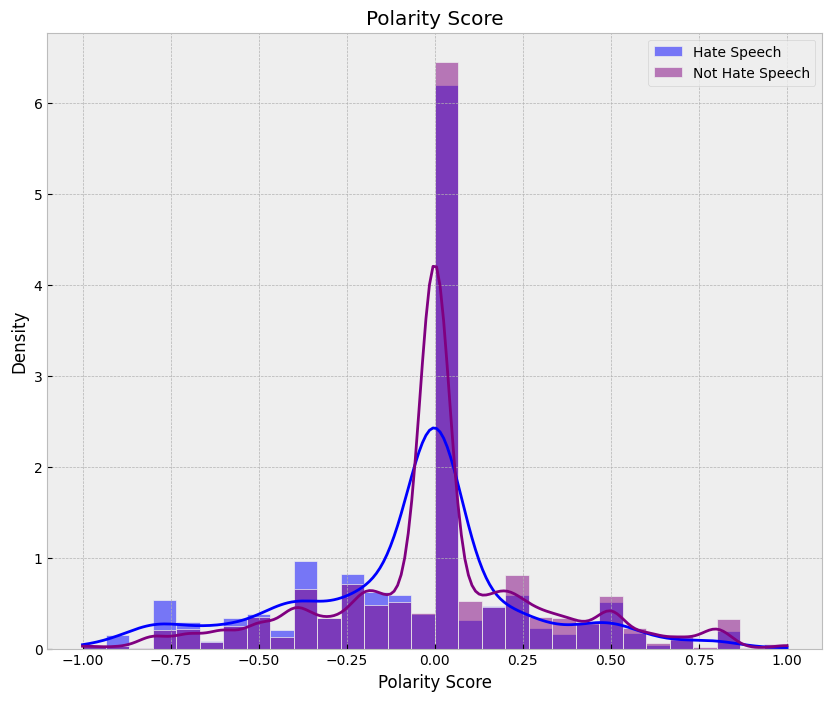

In [ ]:
from textblob import TextBlob

data['polarity_score'] = data['clean_tweets'].apply(lambda x: TextBlob(x).sentiment.polarity)

hate_speech_scores = data[data['label'] == 1]['polarity_score']
non_hate_speech_scores = data[data['label'] == 0]['polarity_score']


plt.figure(figsize=(10, 8))
sns.histplot(hate_speech_scores, color='blue', kde=True, label='Hate Speech', stat='density', bins=30)
sns.histplot(non_hate_speech_scores, color='purple', kde=True, label='Not Hate Speech', stat='density', bins=30)
plt.title('Polarity Score')
plt.xlabel('Polarity Score')
plt.ylabel('Density')
plt.legend()
plt.show()


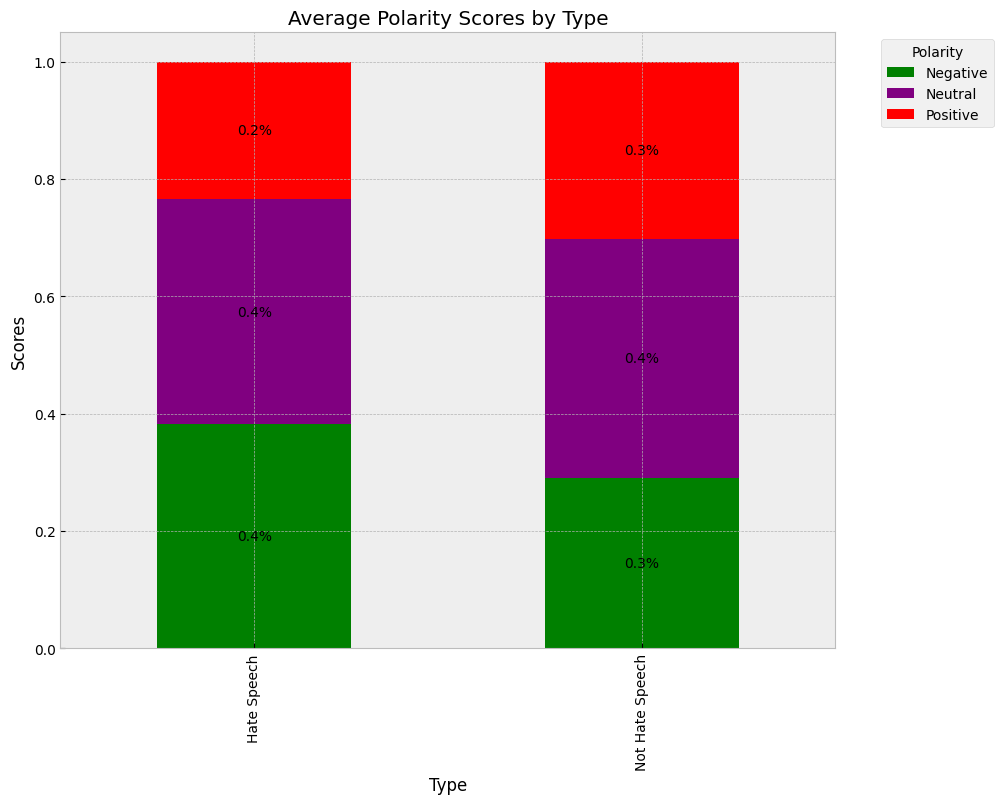

In [ ]:
data['polarity_category'] = data['polarity_score'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

hate_speech_polarity = data[data['label'] == 1]['polarity_category'].value_counts(normalize=True)
non_hate_speech_polarity = data[data['label'] == 0]['polarity_category'].value_counts(normalize=True)

polarity_df = pd.DataFrame({
    'Hate Speech': hate_speech_polarity,
    'Not Hate Speech': non_hate_speech_polarity
}).T

polarity_df.plot(kind='bar', stacked=True, figsize=(10, 8), color=['green', 'purple', 'red'])
plt.title('Average Polarity Scores by Type')
plt.xlabel('Type')
plt.ylabel('Scores')
plt.legend(title='Polarity', bbox_to_anchor=(1.05, 1), loc='upper left')
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.1f%%', label_type='center')
plt.show()


<ipython-input-26-1d68d552dce1>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='bigram', data=bigrams_df, palette='viridis')


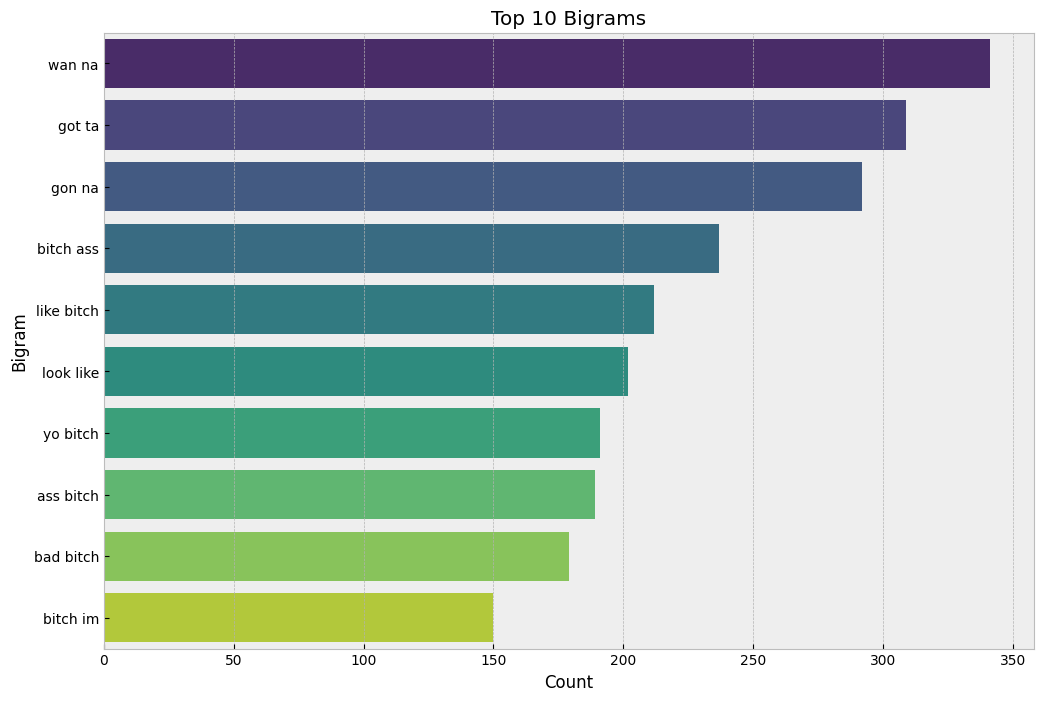

<ipython-input-26-1d68d552dce1>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='trigram', data=trigrams_df, palette='viridis')


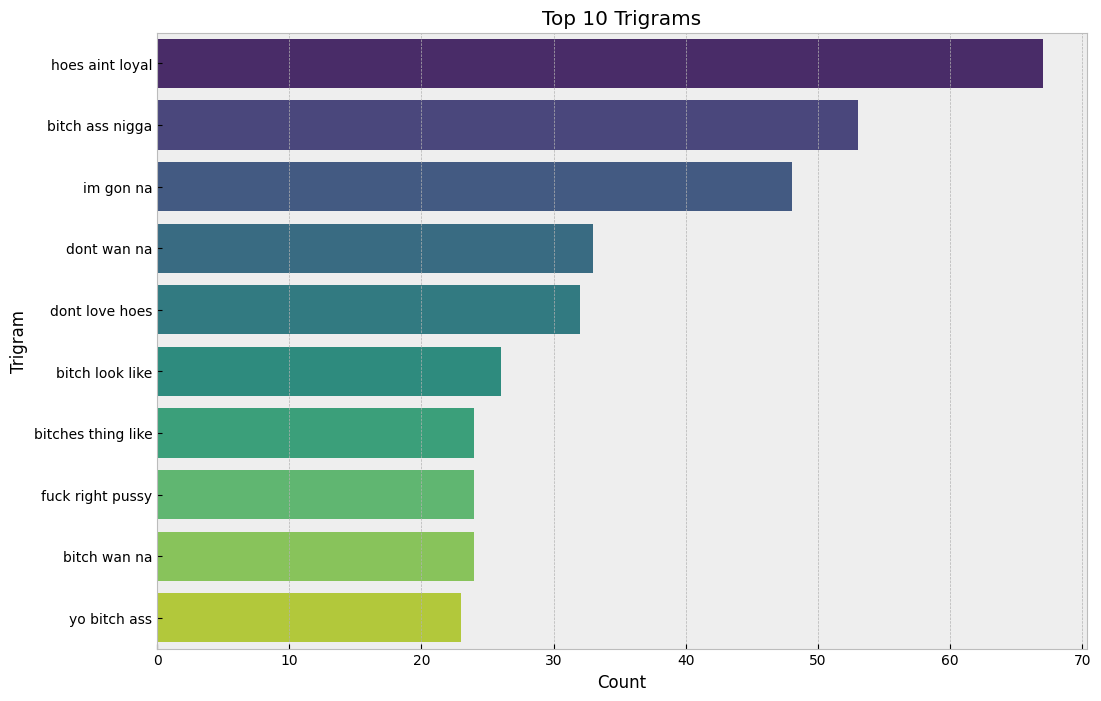

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_grams(corpus, ngram_range, n=None):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

top_bigrams = get_top_n_grams(data['cleaned_no_stopwords'], (2, 2), 10)
top_trigrams = get_top_n_grams(data['cleaned_no_stopwords'], (3, 3), 10)

bigrams_df = pd.DataFrame(top_bigrams, columns=['bigram', 'count'])
trigrams_df = pd.DataFrame(top_trigrams, columns=['trigram', 'count'])

plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='bigram', data=bigrams_df, palette='viridis')
plt.title('Top 10 Bigrams')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='trigram', data=trigrams_df, palette='viridis')
plt.title('Top 10 Trigrams')
plt.xlabel('Count')
plt.ylabel('Trigram')
plt.show()
